In [1]:
import json
import os
from glob import glob
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm_notebook as tqdm
import sys

In [2]:
txt_path = '/home/nikolay/workspace/mfo/data/total/00220-05001_0879f88b-245b-11e5-81f6-f01fafe92f9d/00220-05001.txt'
with open(txt_path) as json_file:
    data = json.load(json_file)
data

{'ЗаймНомер': 'Н0022005001',
 'ЗаймДата': '2020-01-22T11:56:21',
 'ПланДата': '2020-02-07T00:00:00',
 'ЗаймСумма': 1000,
 'РезультатНейросеть': '1',
 'МассивФото': ['2ae021d0-43f5-4c91-95f0-0f72eca1b07b',
  'e08312ed-c41c-4947-8179-88f2c492aea9',
  '1a1671e6-c701-4a0c-a20e-dd35126500f1',
  'cd0a759a-4658-4f51-9531-13dd726bd2a8',
  '79df150a-ee5d-48ea-ad39-816eb17eb554',
  'b888fe78-0972-4c50-96f1-1dce1d232edb',
  'c364a4e4-fef9-49da-9e37-9f4b26c08261',
  '13ac9b24-bce8-4c2e-bcab-2bfe92d25f15',
  '04aaa1e6-68ea-47f4-af8b-9f0d036117db',
  '965324a0-49fb-4608-9a66-cbbb549c21d0'],
 'Персона': {'ДатаРождения': '1983-06-23T00:00:00',
  'АдресРегистрацииИндекс': '443093',
  'АдресРегистрацииРегион': 'Самарская обл',
  'АдресРегистрацииРайон': '',
  'АдресРегистрацииГород': 'Самара г',
  'АдресРегистрацииНасПункт': '',
  'АдресРегистрацииУлица': 'Мориса Тореза ул',
  'АдресФактическогоПроживанияИндекс': '443093',
  'АдресФактическогоПроживанияРегион': 'Самарская обл',
  'АдресФактическогоПрожи

In [6]:
# '''### TXT PARSING
def parse_txt_in_folder(path):
    df = pd.DataFrame()
    df['loan_finished'] = None

    for folder_num, folder_name in enumerate(tqdm(os.listdir(path)[:])):

        folder_path = os.path.join(path, folder_name)
        i = [i for i in os.listdir(folder_path) if i.endswith('txt')]
        txt_path = os.path.join(folder_path, i[0])
        try:
            with open(txt_path) as json_file:
                data = json.load(json_file)
        except:
            df.at[folder_num, 'folder_name'] = folder_name


        ### parse txt file
        trans_ids = data.keys()
        total_given    = 0
        loan_etap_list = []
        total_taken = 0 

        loan    = data
        history = loan['История']

        total_taken += loan['ЗаймСумма'] ### total_taken

        for key in history.keys():
            if key.startswith('Оплата'):
                total_given += history[key]['СуммаОД']
                total_given += history[key]['СуммаПроцент']

            if key.startswith('Увеличение'): 
                total_taken += history[key]['СуммаОД']

            if key.startswith('Закрытие'): 
                df.at[folder_num, 'loan_finished'] = 1
                total_given += history[key]['СуммаОД']
                total_given += history[key]['СуммаПроцент']
                loan_etap_list.append(history['Закрытие']['Этап'])

            if key.startswith('Пролонгация'):
                df.at[folder_num, 'prolong'] = 1

        person         = loan['Персона']
        date_of_birth  = person['ДатаРождения'][:10]
        adress_index   = person['АдресФактическогоПроживанияИндекс']
        adress_region  = person['АдресФактическогоПроживанияРегион']
        source         = person['ИсточникИнформации']
        childs         = person['КоличествоИждевенцев']
        education      = person['Образование']
        job            = person['ОрганизацияДолжность']
        gender         = person['Пол']
        marital_status = person['СемейноеСтатус']

        ### add data to df
#         df.at[folder_num, 'РезультатНейросеть'] = loan['РезультатНейросеть']
        df.at[folder_num, 'folder_name'] = folder_name
        df.at[folder_num, 'date_of_birth'] = date_of_birth
        df.at[folder_num, 'loan_date'] = loan['ЗаймДата'][:10]
        df.at[folder_num, 'loan_end_date'] = loan['ПланДата'][:10]
        df.at[folder_num, 'adress_index'] = adress_index
        df.at[folder_num, 'adress_region'] = adress_region
        df.at[folder_num, 'source'] = source
        df.at[folder_num, 'childs'] = childs
        df.at[folder_num, 'education'] = education
        df.at[folder_num, 'job'] = job
        df.at[folder_num, 'gender'] = gender
        df.at[folder_num, 'marital_status'] = marital_status
        df.at[folder_num, 'total_taken'] = total_taken
        df.at[folder_num, 'total_given'] = total_given
        df.at[folder_num, 'loan_etap_median'] = np.median(loan_etap_list)
        df.at[folder_num, 'loan_etap_max'] = (np.max(loan_etap_list) if len(loan_etap_list) > 0 else np.nan) 

    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], errors='coerce', format="%Y-%m-%d")
    df['loan_date'] = pd.to_datetime(df['loan_date'], errors='coerce', format="%Y-%m-%d")
    df['date_of_birth'].fillna(value=pd.to_datetime('1/1/1984'), inplace=True) 
    df['loan_finished'] = df['loan_finished'].fillna(0)
    df['prolong'] = df['prolong'].fillna(0)
    df['total_profit'] = df['total_given'] - df['total_taken']
    df['total_profit_percent'] = df['total_profit'] / df['total_taken']
    df['age'] = (df['loan_date'] - df['date_of_birth']).astype('<m8[Y]')
    # df = df.join(dff)
    # df = df[df['Верхнее веко'].isna()==False]

    return df

df = parse_txt_in_folder('../data/total')
df

/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,loan_finished,folder_name,date_of_birth,loan_date,loan_end_date,adress_index,adress_region,source,childs,education,...,gender,marital_status,total_taken,total_given,loan_etap_median,loan_etap_max,prolong,total_profit,total_profit_percent,age
0,1,63219-39006_49363450-d9f8-11e9-997d-00155d2d0507,1960-12-08,2019-09-18,2019-10-04,445042,Самарская обл,Звонок КС,0.0,,...,Женский,Женат / Замужем,6000.0,6000.00,1.0,1.0,0.0,0.00,0.000000,58.0
1,0,61519-40024_5f02d0ad-8ccf-11e9-997a-00155d2d0507,1990-09-28,2019-09-27,2019-10-13,446100,Самарская обл,Звонок КС,1.0,Средне-специальное,...,Женский,Женат / Замужем,8000.0,3680.00,NaN,NaN,1.0,-4320.00,-0.540000,28.0
2,1,63920-05007_df0dd703-3bb2-11ea-997f-00155d2d0507,1995-04-01,2020-01-21,2020-02-06,187556,Ленинградская обл,Интернет,0.0,,...,Мужской,Холост / Не замужем,5000.0,5902.74,1.0,1.0,0.0,902.74,0.180548,24.0
3,0,61819-42007_d44db0ac-0aac-11e6-a141-f01fafe92f9d,1967-10-02,2019-10-09,2019-10-25,460022,Оренбургская обл,Звонок КС,1.0,Средне-специальное,...,Мужской,Женат / Замужем,3000.0,0.00,NaN,NaN,0.0,-3000.00,-1.000000,52.0
4,0,63419-39007_cf6a1ebb-d945-11e9-997d-00155d2d0507,1991-07-18,2019-09-17,2019-10-03,443091,Самарская обл,Банер / Короб на офисе,1.0,,...,Женский,Холост / Не замужем,2000.0,0.00,NaN,NaN,0.0,-2000.00,-1.000000,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,1,62720-19009_9cf6e463-fdb5-11e3-b883-f01fafe92f9d,1945-03-20,2020-05-02,2020-05-18,446115,Самарская обл,Банер / Короб на офисе,0.0,Среднее,...,Женский,Холост / Не замужем,3000.0,3060.00,1.0,1.0,0.0,60.00,0.020000,75.0
9667,1,63119-40002_e7e128cd-dde0-11e9-997d-00155d2d0507,1987-04-20,2019-09-23,2019-10-09,446253,Самарская обл,Звонок КС,0.0,среднее-профессиональное,...,Мужской,Холост / Не замужем,2000.0,2000.00,1.0,1.0,0.0,0.00,0.000000,32.0
9668,0,61819-40016_09597111-c79a-11e9-997d-00155d2d0507,1988-10-22,2019-09-28,2019-10-14,460052,Оренбургская обл,Звонок КС,1.0,Высшее,...,Женский,Женат / Замужем,8000.0,1300.00,NaN,NaN,1.0,-6700.00,-0.837500,30.0
9669,1,62419-51002_99c8f5e2-1a48-11ea-997d-00155d2d0507,1970-10-28,2019-12-09,2019-12-25,446455,Самарская обл,Звонок КС,0.0,Средне-специальное,...,Мужской,Женат / Замужем,2000.0,2000.00,1.0,1.0,0.0,0.00,0.000000,49.0


In [10]:
# df.to_pickle('../data/total.pkl')

<AxesSubplot:xlabel='loan_date', ylabel='Count'>

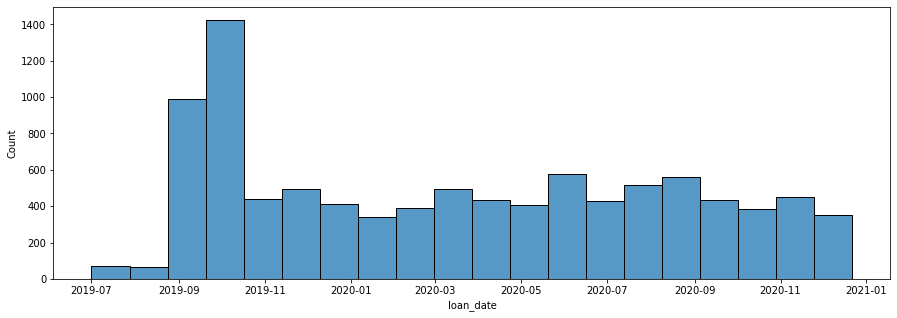

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
sns.histplot(data=df, x="loan_date")